In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import geopy.distance as geo
import json
import time
warnings.filterwarnings(action="ignore")
%matplotlib inline

In [3]:
df = pd.read_csv('../input/availability.csv')

In [4]:
df = df[df['station_status'] == 'In Service']
df = df[df['borough'] != 'New Jersey']
df['hour'] = df['time_interval'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1].split(':')[0] + ':00:00')

In [5]:
hoods = df.groupby(['borough','hood', 'hour'])['available_bikes','available_docks', 'hour'].sum().reset_index()
hoods['total_available'] = hoods.apply(lambda x: x['available_bikes'] + x['available_docks'], axis=1)
hoods['percent_available'] = hoods.apply(lambda x: x['available_bikes'] / x['total_available'], axis=1)
hoods_filtered = hoods[hoods['total_available'] > 1573]

In [7]:
hoods_filtered.describe()

,available_bikes,available_docks,total_available,percent_available
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,879.285167,1740.488232,2619.773399,0.352704
std,433.278059,810.065073,849.382235,0.179625
min,4.000000,53.000000,1574.000000,0.001328
25%,536.000000,1105.500000,1987.500000,0.223601
50%,873.000000,1572.000000,2426.000000,0.355128
75%,1238.500000,2349.500000,3115.000000,0.459329
max,1957.000000,3776.000000,4273.000000,0.966519


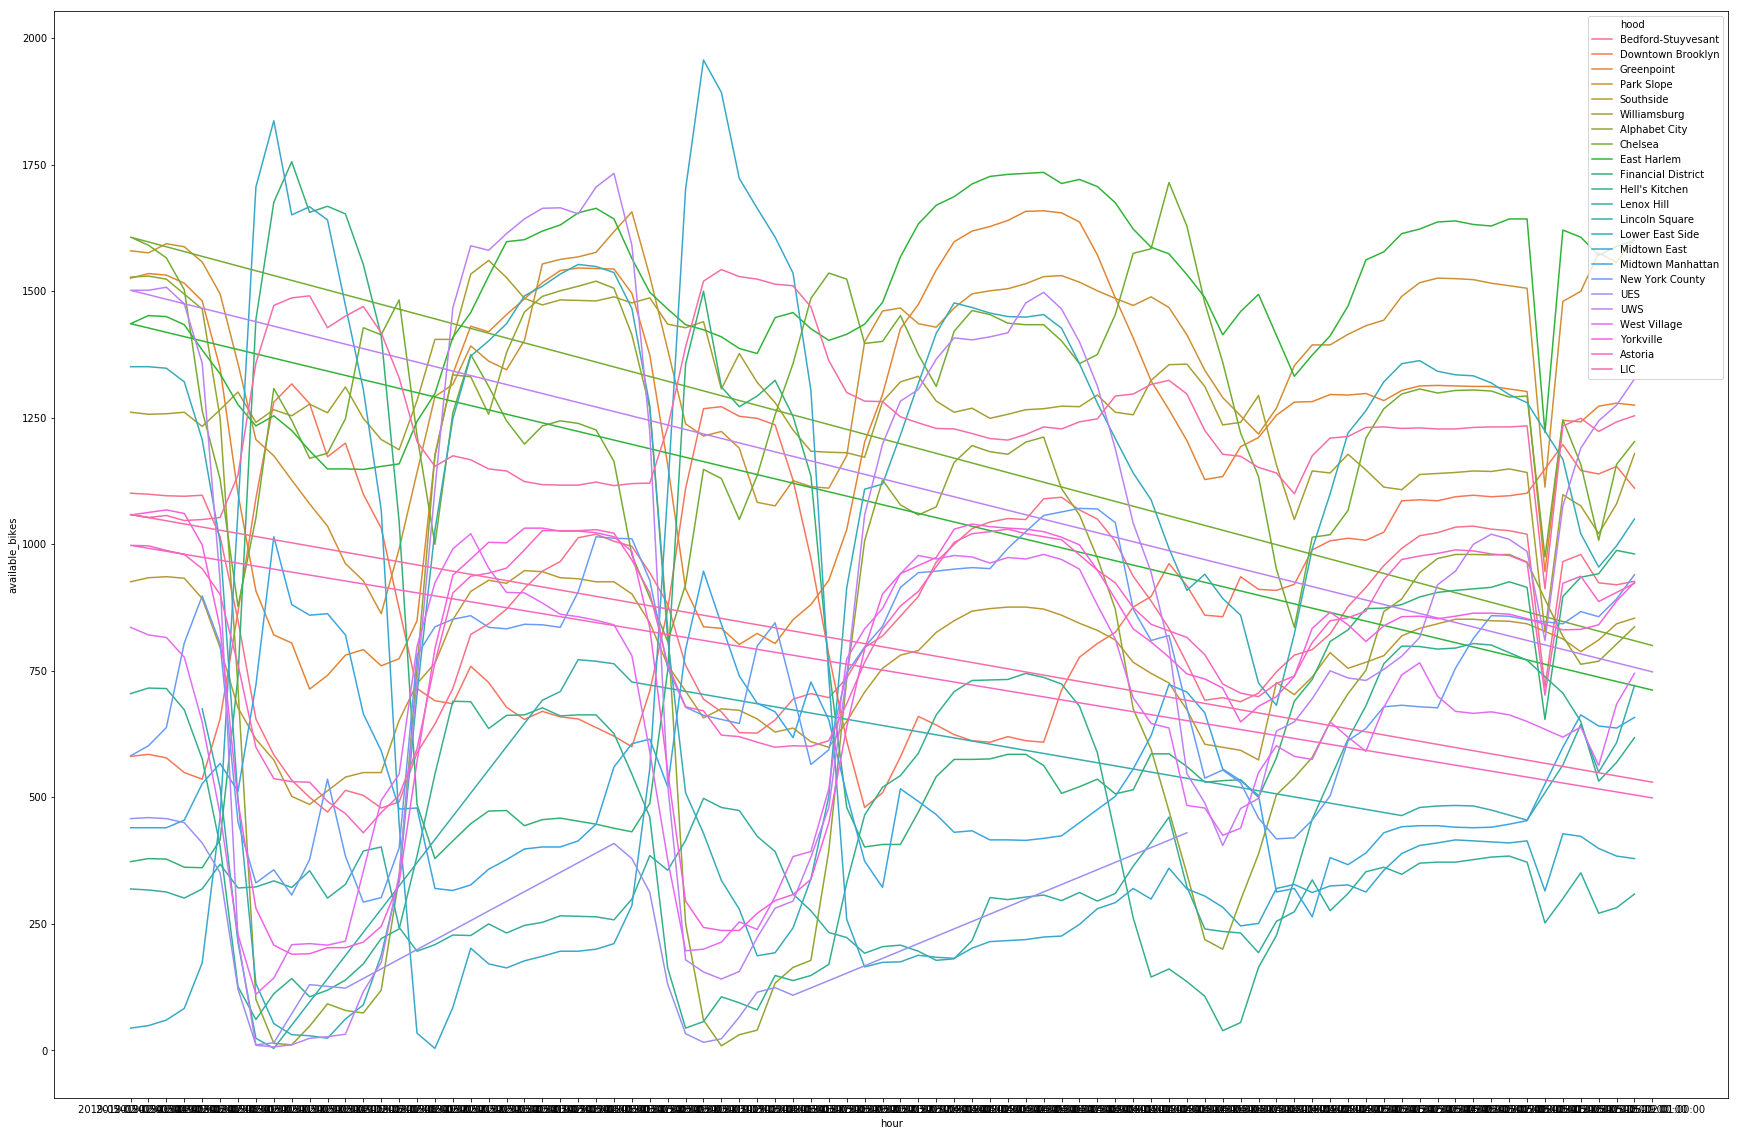

In [8]:
plt.figure(figsize=(30, 20))
sns.set_palette('Set2')
sns.lineplot(x='hour', y='available_bikes', data=hoods_filtered, hue='hood', ci=90)

In [9]:
df = df.groupby(['station_id', 'latitude', 'longitude', 'borough', 'station_status']).mean()
df = df.reset_index()
df = df.set_index('station_id')
df.head()

In [14]:
def getDistance(x, y):
    return geo.distance(x, y).km

closest_stations = {}

for stationX in df.index:
    closest_stations[stationX] = []
    for stationY in df.index:
        if stationX != stationY:
            try:
                distance = getDistance((df.loc[stationX, 'latitude'], df.loc[stationX, 'longitude']),(df.loc[stationY, 'latitude'], df.loc[stationY, 'longitude']))
                y_in_service = df.loc[stationY, 'station_status'] == 'In Service'
            except:
                print('Error')
                print('x:', stationX)
                print('y:', stationY)
                break
            if distance < .5 and y_in_service:
                closest_stations[stationX].append({'station_id': stationY, 'distance': distance})

contents = json.dumps(closest_stations)
file = open("../output/nearby_stations.json","a")
file.write(contents)
file.close()

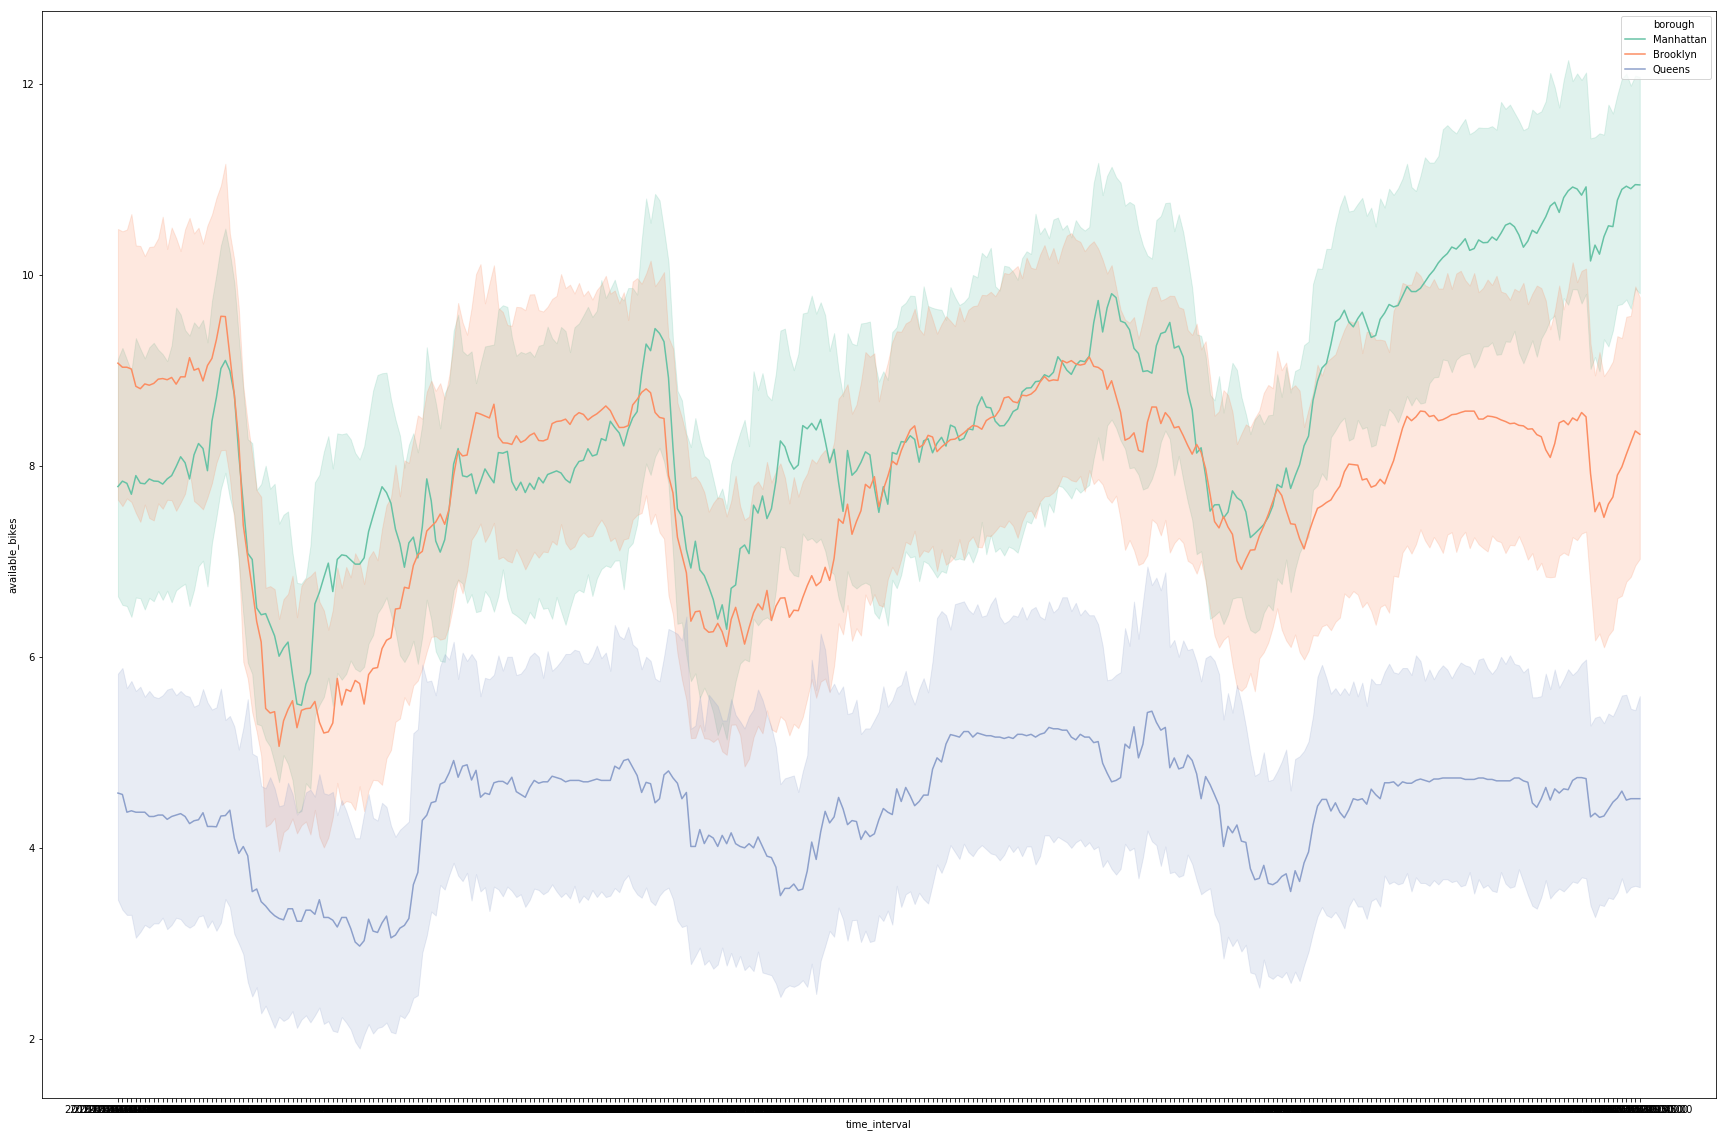

In [7]:
plt.figure(figsize=(30, 20))
sns.set_palette('Set2')
sns.lineplot(x='time_interval', y='available_bikes', data=df, hue='borough', ci=99)